I conduct exploratory data analysis around the features presented in the NYPD data set. 
- Any outliers? 
- Anything stick out as interesting trends within the data?

Then I fit a logistic regression model and predict whether or not an arrest was made, in the event of a police frisking. I initially begin with a logistic regression with all features. Then, I break it down to a more interpretable model with less features, so that it is an actionable model to present to the NYPD.

In [1]:
# Import Libaries
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import libraries
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [4]:
## import data
df = pd.read_csv('nypd.csv', low_memory=False)

## quick stats
df.describe

<bound method NDFrame.describe of         pct  ser_num  datestop  timestop recstat inout trhsloc       crimsusp  \
0         1        2   1012013       452       1     I       T  GRAND LARCENY   
1         1        3   1012013       315       1     I       T  GRAND LARCENY   
2         1        7   1012013       300       1     I       T        ROBBERY   
3         1       11   1012013      1212       A     O       P        ROBBERY   
4         1       12   1012013      2300       A     O       P       BURGLARY   
...     ...      ...       ...       ...     ...   ...     ...            ...   
191846   45     1160  12312013      2320       1     O       H         FELONY   
191847    9     2338  12312013      2337       1     O       P         FELONY   
191848   49     1645  12312013      2350       A     O       P         FELONY   
191849   49     1647  12312013      2350       A     O       P         FELONY   
191850   44     3485  12312013      2350       A     O       P            C

In [5]:
# Looks like we have a pretty large dataset (191,851 rows). Let's check to see if there are any NA values
# and simply drop them from our set.

df.isna().sum()
df.dropna

<bound method DataFrame.dropna of         pct  ser_num  datestop  timestop recstat inout trhsloc       crimsusp  \
0         1        2   1012013       452       1     I       T  GRAND LARCENY   
1         1        3   1012013       315       1     I       T  GRAND LARCENY   
2         1        7   1012013       300       1     I       T        ROBBERY   
3         1       11   1012013      1212       A     O       P        ROBBERY   
4         1       12   1012013      2300       A     O       P       BURGLARY   
...     ...      ...       ...       ...     ...   ...     ...            ...   
191846   45     1160  12312013      2320       1     O       H         FELONY   
191847    9     2338  12312013      2337       1     O       P         FELONY   
191848   49     1645  12312013      2350       A     O       P         FELONY   
191849   49     1647  12312013      2350       A     O       P         FELONY   
191850   44     3485  12312013      2350       A     O       P            C

In [6]:
# 'crimsusp' column could be of value for insights later.
df['crimsusp'].value_counts().sort_values(ascending=False)

FEL                        36028
FELONY                     32358
MISD                       28386
CPW                        20533
ROBBERY                    13609
                           ...  
FEL  / BURGLARY PATTERN        1
CWP (FEL)                      1
UNLAWFULOF FARE MEDIA          1
MIS/MAKING GRAFFITTI           1
PROHIBITED SALE OF ALCO        1
Name: crimsusp, Length: 2615, dtype: int64

### We see there are many variations of different crimes that were suspected by the police. We will need to combine some values here.

In [7]:
## crimsusp appears to be something we can predict off, let's take a deeper look
cs_cts = df['crimsusp'].value_counts().sort_values(ascending=False)
cs_cts = cs_cts[cs_cts > 150]

print(cs_cts)

FEL                   36028
FELONY                32358
MISD                  28386
CPW                   20533
ROBBERY               13609
BURGLARY               8016
GLA                    5668
CPM                    3587
GRAND LARCENY          3470
ASSAULT                2734
MISDEMEANOR            2621
CRIMINAL TRESPASS      2278
BURG                   1995
CPCS                   1698
CRIM TRES              1634
PETIT LARCENY          1538
CSCS                   1365
FELONY/ROBBERY         1041
MIS                    1039
ROB                     849
F                       677
M                       638
CRIMINAL MISCHIEF       542
G/L                     533
MIS/CPW                 526
FELONY/BURG             521
GRAFFITI                498
MAKING GRAFFITI         442
FEL/BURG                418
CPSP                    385
FEL/CPW                 379
CRIM TRESS              343
ASSAULT 3               331
CT                      320
GRAND LARC              308
CRIM TRESPASS       

### The good news is that we've accounted for missing values earlier. The bad news is that we have different variations of how "crime suspected" was recorded. This makes sense since different officers may have their preference of entering their personal notes. Let's try to use some intuition in cleaning these columns up.

In [8]:
cs_cts.index.values

array(['FEL', 'FELONY', 'MISD', 'CPW', 'ROBBERY', 'BURGLARY', 'GLA',
       'CPM', 'GRAND LARCENY', 'ASSAULT', 'MISDEMEANOR',
       'CRIMINAL TRESPASS', 'BURG', 'CPCS', 'CRIM TRES', 'PETIT LARCENY',
       'CSCS', 'FELONY/ROBBERY', 'MIS', 'ROB', 'F', 'M',
       'CRIMINAL MISCHIEF', 'G/L', 'MIS/CPW', 'FELONY/BURG', 'GRAFFITI',
       'MAKING GRAFFITI', 'FEL/BURG', 'CPSP', 'FEL/CPW', 'CRIM TRESS',
       'ASSAULT 3', 'CT', 'GRAND LARC', 'CRIM TRESPASS', 'USFM',
       'ROBBERY (FEL)', 'GRAND LARCENY AUTO', 'ROBB', 'BURGLARY (FEL)',
       'CRIM MIS', 'FELONY/GLA', 'FEL/GLA', 'FEL.', 'MIS/ASSAULT',
       'FEL  / CPW', 'AUTO STRIPPING', 'TRESPASS'], dtype=object)

In [9]:
df = df[df['crimsusp'].isin(cs_cts.index.values)]

### Still seems we can clean the data further

In [10]:
# Replace values remotely close to 'FELONY'
fel_rows = df.loc[df['crimsusp'].isin(['FEL', 'FEL/ASSAULT', 'F', 'FEL.'])].index.values
df.loc[fel_rows, 'crimsusp'] = 'FELONY'

# Replace things that get close to 'BURGLARY'
burg_rows = df.loc[df['crimsusp'].isin(['BURG', 'BURGLARY (FEL)', 'FEL/BURG', 'FELONY/BURG'])].index.values
df.loc[burg_rows, 'crimsusp'] = 'BURGLARY'

# Replace values remotely close to 'MISDEMEANOR'
mis_rows = df.loc[df['crimsusp'].isin(['MIS', 'M', 'MISD'])].index.values
df.loc[mis_rows, 'crimsusp'] = 'MISDEMEANOR'

# Replace values remotely close to 'ROBBERY'
rob_rows = df.loc[df['crimsusp'].isin(['ROB', 'ROBBERY (FEL)', 'ROBB', 'FELONY/ROBBERY'])].index.values
df.loc[rob_rows, 'crimsusp'] = 'ROBBERY'

# Replace values remotely close to 'CRIMINAL TRESPASS'
crim_rows = df.loc[df['crimsusp'].isin(['CRIM TRESS', 'TRESPASS', 'CT', 'CRIM TRESPASS', 'CRIM TRES'])].index.values
df.loc[crim_rows, 'crimsusp'] = 'CRIMINAL TRESPASS'

# Replace values remotely close to 'GRAFFITI'
graf_rows = df.loc[df['crimsusp'].isin(['MAKING GRAFFITI'])].index.values
df.loc[graf_rows, 'crimsusp'] = 'GRAFFITI'

# Replace values remotely close to 'ASSAULT'
as_rows = df.loc[df['crimsusp'].isin(['ASSAULT 3', 'MIS/ASSAULT'])].index.values
df.loc[as_rows, 'crimsusp'] = 'ASSAULT'

# Replace values remotely close to 'ASSAULT'
as_rows = df.loc[df['crimsusp'].isin(['ASSAULT 3'])].index.values
df.loc[as_rows, 'crimsusp'] = 'ASSAULT'

# Replace values remotely close to 'CRIMINAL MISCHIEF'
cm_rows = df.loc[df['crimsusp'].isin(['CRIM MIS'])].index.values
df.loc[cm_rows, 'crimsusp'] = 'CRIMINAL MISCHIEF'

# Replace values remotely close to 'GRAND LARCENY'
gc_rows = df.loc[df['crimsusp'].isin(['GRAND LARC', 'G/L', 'GLA', 'GRAND LARCENY AUTO', 'FEL/GLA', 'FELONY/GLA'])].index.values
df.loc[gc_rows, 'crimsusp'] = 'GRAND LARCENY'

# Replace values remotely close to 'CPW'
cpw_rows = df.loc[df['crimsusp'].isin(['FEL  / CPW', 'FEL/CPW','MIS/CPW'])].index.values
df.loc[cpw_rows, 'crimsusp'] = 'CPW'

In [11]:
df['crimsusp'].value_counts().sort_index()

ASSAULT               3227
AUTO STRIPPING         157
BURGLARY             11158
CPCS                  1698
CPM                   3587
CPSP                   385
CPW                  21597
CRIMINAL MISCHIEF      747
CRIMINAL TRESPASS     5011
CSCS                  1365
FELONY               69240
GRAFFITI               940
GRAND LARCENY        10576
MISDEMEANOR          32684
PETIT LARCENY         1538
ROBBERY              15934
USFM                   279
Name: crimsusp, dtype: int64

### Fantastic! It looks like we got down to 17 values for the *crimsusp* column, as opposed to the initial 2615!

In [12]:
# Saving to a .csv in case!
df.to_csv('nypd_cleaned.csv', sep = ",")

In [3]:
df = pd.read_csv('ny_cleaned.csv')
y = df['arstmade']

## Data Exploration

In [4]:
df['arstmade'].value_counts() ## Let's explore the ratio of those who were actualy arrested

N    166195
Y     13928
Name: arstmade, dtype: int64

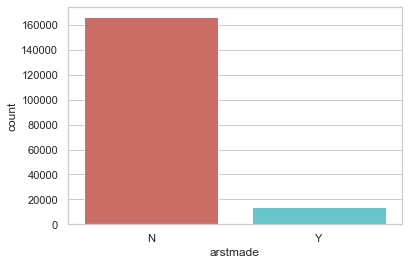

In [5]:
sns.countplot(x='arstmade', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [6]:
# We see that our classes are imbalanced, so we'll need to account for this when splitting our training + test sets
count_no_arst = len(df[df['arstmade']=='N'])
count_arst = len(df[df['arstmade']=='Y'])
pct_of_no_arst = count_no_arst/(count_no_arst + count_arst)
print("Percentage of no arrest made:", pct_of_no_arst*100)
pct_of_arst = count_arst/(count_no_arst + count_arst)
print("Percentage of an arrest made:", pct_of_arst*100)

Percentage of no arrest made: 92.26750609305864
Percentage of an arrest made: 7.732493906941368


### Deeper Dive

In [7]:
df.groupby('arstmade').mean()

,Unnamed: 0,pct,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
arstmade,,,,,,,,,,,
N,94118.705400,69.711483,1725.304570,4.095301e+06,1391.680472,223.171479,5.196167,6.375174,68.729180,170.007533,69.711483
Y,110418.881031,62.224153,1823.374426,5.085841e+06,1370.439833,270.340034,5.204696,6.193926,68.650273,170.964747,62.224153


Observations
- Most of these variables are unique (precinct numbers or serial numbers), and do not provide much insight.
- Datestop can be a variable of interest, as more arrests happened in the later months.
- Those arrested seemed to weigh slightly more, on average, than those who were not arrested.

#### Let's look at some categorical variables (that are not unique) for insights. There are a lot!

In [8]:
df.groupby('inout').mean() # Was whether or not a suspect being frisked inside or outside important to arrest?

,Unnamed: 0,pct,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
inout,,,,,,,,,,,
I,84851.732190,54.649820,1602.619158,3.705134e+06,1417.890545,501.385042,5.184346,6.247733,68.459883,168.008076,54.649820
O,98408.001666,73.299418,1770.368064,4.306189e+06,1382.024457,147.821952,5.200418,6.393793,68.798803,170.678120,73.299418


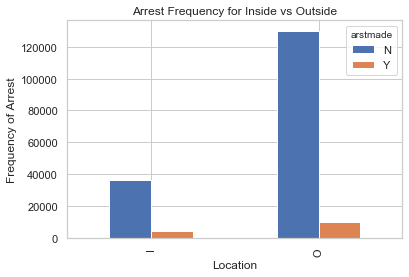

In [9]:
%matplotlib inline
pd.crosstab(df.inout,df.arstmade).plot(kind='bar')
plt.title('Arrest Frequency for Inside vs Outside')
plt.xlabel('Location')
plt.ylabel('Frequency of Arrest')
plt.savefig('arrest_freq_inout')

# Doesn't seem location would play a role in prediction.

In [10]:
df.groupby('crimsusp').mean() # Was the type of crime they were suspected of crucial to the arrest?

,Unnamed: 0,pct,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
crimsusp,,,,,,,,,,,
ASSAULT,104995.821196,69.936164,1708.085218,4.543671e+06,1223.016734,180.300899,5.185002,6.157422,68.377440,168.374961,69.936164
AUTO STRIPPING,111334.108280,68.847134,1504.636943,4.918574e+06,1015.184713,95.942675,5.171975,6.770701,68.834395,173.777070,68.847134
BURGLARY,93709.754705,82.262861,1467.077792,3.989286e+06,1297.413067,93.707026,5.186772,6.346299,68.587560,171.262413,82.262861
CPCS,97109.068905,69.927562,1638.696702,4.285723e+06,1440.735571,166.654888,5.199058,6.328033,68.716726,172.492933,69.927562
CPM,94888.671034,68.566769,1704.945079,4.142732e+06,1528.232506,332.695567,5.202398,6.221912,68.650683,167.999164,68.566769
CPSP,105977.327273,73.462338,1675.018182,4.621078e+06,1362.038961,156.264935,5.168831,6.498701,68.524675,169.677922,73.462338
CPW,95331.007825,67.798213,1920.567070,4.188831e+06,1408.328379,193.055563,5.213085,6.422281,68.979303,172.569292,67.798213
CRIMINAL MISCHIEF,105398.082999,65.183400,1570.069612,4.623981e+06,1209.568942,280.900937,5.165997,6.392236,68.384203,166.547523,65.183400
CRIMINAL TRESPASS,87168.836959,61.913590,1701.335662,3.806168e+06,1435.725205,387.168230,5.159848,6.293355,68.211535,165.991219,61.913590


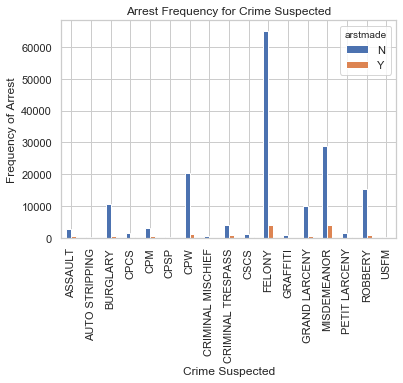

In [11]:
%matplotlib inline
pd.crosstab(df.crimsusp,df.arstmade).plot(kind='bar')
plt.title('Arrest Frequency for Crime Suspected')
plt.xlabel('Crime Suspected')
plt.ylabel('Frequency of Arrest')
plt.savefig('arrest_freq_crimsusp')

# Crime Suspected may play a role in prediction, as some crimes do not have any arrests associated with them.

In [12]:
df.groupby('ac_incid').mean() # Did suspect being stopped in an area of high crime incidence, contribute to the arrest?

,Unnamed: 0,pct,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
ac_incid,,,,,,,,,,,
N,98203.257287,66.834291,1677.710836,4.325205e+06,1369.800819,221.964880,5.194046,6.332311,68.660865,170.282921,66.834291
Y,93409.694403,70.735205,1771.365596,4.064983e+06,1404.150509,230.203666,5.198766,6.381276,68.766462,169.941123,70.735205


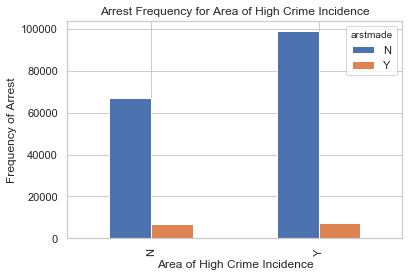

In [13]:
%matplotlib inline
pd.crosstab(df.ac_incid,df.arstmade).plot(kind='bar')
plt.title('Arrest Frequency for Area of High Crime Incidence')
plt.xlabel('Area of High Crime Incidence')
plt.ylabel('Frequency of Arrest')
plt.savefig('arrest_freq_acincid')

#We might have assumed that if an area of high crime would have resulted in more arrests, 
#but arrests seemed to be made in all areas with no discrimination. This probably would not 
#be a good predictor in our model.

In [14]:
df.groupby('sex').mean()

,Unnamed: 0,pct,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
sex,,,,,,,,,,,
F,93445.686450,64.597300,1683.211311,4.070013e+06,1389.081001,278.420234,5.012265,5.109730,65.256915,147.612200,64.597300
M,95587.676018,69.496014,1734.816958,4.182333e+06,1390.295061,223.180798,5.210369,6.454248,68.978672,171.728258,69.496014
Z,89035.088536,66.111805,1893.399546,3.889578e+06,1372.391033,214.234393,5.191827,6.207719,68.509648,169.657775,66.111805


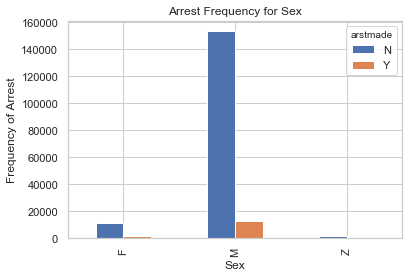

In [15]:
%matplotlib inline
pd.crosstab(df.sex,df.arstmade).plot(kind='bar')
plt.title('Arrest Frequency for Sex')
plt.xlabel('Sex')
plt.ylabel('Frequency of Arrest')
plt.savefig('arrest_freq_sex')

Sex seems to be a good predictor. It seems on average, that if females were indeed stopped, they had a higher ratio/chance of being arrested.

In [16]:
df.groupby('race').mean()

,Unnamed: 0,pct,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
race,,,,,,,,,,,
A,100593.245048,85.024413,1504.183019,4.452966e+06,1342.425610,149.346384,5.106863,6.655151,67.937510,162.002917,85.024413
B,94692.343924,69.319473,1949.449978,4.150825e+06,1424.053577,253.260897,5.243279,6.253391,69.172736,171.404181,69.319473
I,95823.196359,78.361508,1501.023407,4.270843e+06,1374.888166,171.336801,5.122237,6.736021,68.202861,170.057217,78.361508
P,94240.969081,56.764634,1561.974032,4.107791e+06,1406.638701,208.100660,5.143825,6.529442,68.255341,170.323606,56.764634
Q,93625.168793,67.475485,1504.921072,4.064995e+06,1342.102048,216.424436,5.103667,6.526808,67.770816,167.803179,67.475485
U,97019.712163,74.209842,1675.346332,4.306442e+06,1329.422470,190.847725,5.181987,6.271123,68.454968,167.902507,74.209842
W,101752.735283,73.813962,1283.838442,4.441699e+06,1328.506665,158.916550,5.221358,6.363882,69.020175,170.737099,73.813962
Z,92337.347249,63.145731,1824.137761,4.112689e+06,1377.189753,200.794687,5.187097,6.299431,68.544592,170.509298,63.145731


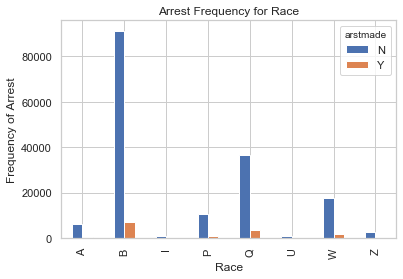

In [17]:
%matplotlib inline
pd.crosstab(df.race,df.arstmade).plot(kind='bar')
plt.title('Arrest Frequency for Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Arrest')
plt.savefig('arrest_freq_race')

#Race could be a good predictor, as some races had little to no arrests.

In [18]:
df.groupby('pct').mean() # Did precinct # matter for arrests?

,Unnamed: 0,ser_num,datestop,timestop,revcmd,ht_feet,ht_inch,height_in,weight,addrpct
pct,,,,,,,,,,
1,94082.468900,580.912679,3.965183e+06,1186.327751,401.215311,5.229665,6.349282,69.105263,172.190191,1.0
5,104020.000000,569.639274,4.440519e+06,1285.458911,200.728922,5.168623,6.389541,68.413020,167.735326,5.0
6,91313.617857,640.938393,3.786736e+06,954.633929,193.209821,5.267857,6.123214,69.337500,173.402679,6.0
7,102003.898643,562.391855,4.627714e+06,1398.981900,358.239819,5.217195,6.323982,68.930317,170.411765,7.0
9,100776.204883,1168.050742,4.398586e+06,1233.343705,271.092389,5.205840,6.248444,68.718526,168.865007,9.0
...,...,...,...,...,...,...,...,...,...,...
115,101561.389573,611.972512,4.327586e+06,1248.333649,288.274882,5.148815,6.253081,68.038863,169.168720,115.0
120,96923.753472,2266.338194,4.360657e+06,1407.177546,137.192130,5.195833,6.413889,68.763889,170.895370,120.0
121,174484.395078,427.389896,8.993386e+06,1221.068653,145.720207,5.242228,6.049223,68.955959,171.423575,121.0


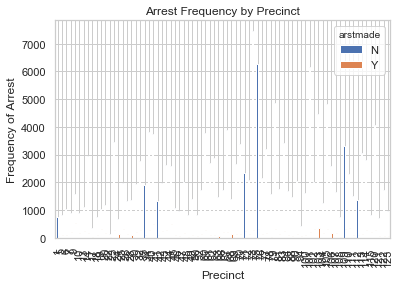

In [19]:
%matplotlib inline
pd.crosstab(df.pct,df.arstmade).plot(kind='bar')
plt.title('Arrest Frequency by Precinct')
plt.xlabel('Precinct')
plt.ylabel('Frequency of Arrest')
plt.savefig('arrest_freq_pct')

# A harder graph to interpret, 
# but we can see that some precincts had more high frequency of arrests than others.


## Create dummies

In [20]:
df.dtypes

Unnamed: 0     int64
pct            int64
ser_num        int64
datestop       int64
timestop       int64
recstat       object
inout         object
trhsloc       object
crimsusp      object
typeofid      object
explnstp      object
othpers       object
arstmade      object
offunif       object
frisked       object
searched      object
ac_proxm      object
rf_attir      object
cs_cloth      object
ac_incid      object
repcmd        object
revcmd         int64
sex           object
race          object
age           object
ht_feet        int64
ht_inch        int64
height_in      int64
weight         int64
haircolr      object
eyecolor      object
build         object
city          object
addrpct        int64
dtype: object

In [21]:
# Convert precinct to OBJECT
df['pct'] = df['pct'].astype('category')


# Convert these OBJECT columns to NUMERIC, so they are not changed as part of the BinaryEncoders code

df['repcmd'] = df['repcmd'].astype('category')
df['repcmd'] = df['repcmd'].cat.codes

df['age'] = df['age'].astype('category')
df['age'] = df['age'].cat.codes

In [22]:
cat_list = ['pct','recstat','inout','trhsloc','crimsusp','typeofid','explnstp','othpers',
 'arstmade','offunif','frisked','searched','ac_proxm','rf_attir','cs_cloth',
'ac_incid','sex','race','hairclr','eyecolor','build','city']

In [23]:
import category_encoders as ce

ce_bin = ce.BinaryEncoder()
df = ce_bin.fit_transform(df)

In [24]:
df['arstmade_0']

df = df.drop('arstmade_1',axis=1) # we will drop this column as our predictor variable will be arstmade_0

In [25]:
## X = dataset, y = target

X = df.loc[:, df.columns != 'arstmade_0']
y = df.loc[:, df.columns == 'arstmade_0']

## Implement Initial Logistic Regression Model

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Per the Rubric instructions, we will utilize a 80/20 split for our training/test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predict + Accuracy score 

In [27]:
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set:', logreg.score(X_test, y_test))

Accuracy of logistic regression classifier on test set: 0.9237751561415684


### Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[33279     0]
 [ 2746     0]]


### Precision + Recall

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     33279
           1       0.00      0.00      0.00      2746

    accuracy                           0.92     36025
   macro avg       0.46      0.50      0.48     36025
weighted avg       0.85      0.92      0.89     36025



## Recursive Feature Elimination

Let's do some RFE to repeatedly see which variables are pivotal to our Logistic Regression model!

In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = df.loc[:, df.columns != 'arstmade_0']
y = df.loc[:, df.columns == 'arstmade_0']

#df_rfe_vars = df.columns.values.tolist()
#y = ['arstmade_0']
#X = [i for i in df_rfe_vars if i not in y]

col_names = list(df.columns.values)

logreg = LogisticRegression()

rfe = RFE(logreg, 10) # select 10 best columns to predict on
rfe = rfe.fit(X, y)

print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), col_names)))

Features sorted by their rank:
[(1, 'arstmade_0'), (1, 'inout_0'), (1, 'offunif_1'), (1, 'pct_2'), (1, 'rf_attir_1'), (1, 'searched_0'), (1, 'sex_1'), (1, 'trhsloc_1'), (1, 'typeofid_1'), (1, 'typeofid_2'), (2, 'ac_proxm_0'), (3, 'ac_incid_0'), (4, 'ac_proxm_1'), (5, 'pct_6'), (6, 'recstat_0'), (7, 'pct_5'), (8, 'crimsusp_3'), (9, 'race_2'), (10, 'pct_3'), (11, 'city_2'), (12, 'build_2'), (13, 'haircolr_3'), (14, 'othpers_1'), (15, 'ht_feet'), (16, 'city_1'), (17, 'pct_4'), (18, 'ht_inch'), (19, 'city_3'), (20, 'race_3'), (21, 'eyecolor_3'), (22, 'age'), (23, 'ac_incid_1'), (24, 'repcmd'), (25, 'explnstp_1'), (26, 'height_in'), (27, 'timestop'), (28, 'ser_num'), (29, 'Unnamed: 0'), (30, 'datestop'), (31, 'pct_7'), (32, 'recstat_1'), (33, 'frisked_0'), (34, 'crimsusp_4'), (35, 'frisked_1'), (36, 'build_1'), (37, 'cs_cloth_1'), (38, 'race_0'), (39, 'crimsusp_5'), (40, 'city_0'), (41, 'trhsloc_2'), (42, 'inout_1'), (43, 'searched_1'), (44, 'offunif_0'), (45, 'othpers_0'), (46, 'race_1'), 

In [35]:
## According to recursive feature elimination, these are the 10 best predictor variables

rfe_cols = ['inout_0', 'offunif_1','pct_2','rf_attir_1','searched_0',
            'sex_1','trhsloc_1','typeofid_1', 'ac_proxm_0','ac_incid_0',]



## Assign new X and y values
X = X[rfe_cols]
y = y['arstmade_0']

According to recursive feature elimination, these are the 10 best predictor variables.

## Logistic Regression (RFE Model Fit)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Per the Rubric instructions, we will utilize a 80/20 split for our training/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predict + Accuracy Score

In [37]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set:', logreg.score(X_test, y_test))

Accuracy of logistic regression classifier on test set: 0.9316030534351145


### Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[32550   729]
 [ 1735  1011]]


### Precision + Recall

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     33279
           1       0.58      0.37      0.45      2746

    accuracy                           0.93     36025
   macro avg       0.77      0.67      0.71     36025
weighted avg       0.92      0.93      0.92     36025



## Observations of LogReg Model #1 (70 predictors) vs LogReg Model #2 (10 predictors):

- Accuracy is much higher with LESS predictors (92% vs 93%)
- Precision score is quite close with LESS predictors (0.92) vs less predictors (0.95)
- Recall is higher with more predictors (1.0) vs less predictors (0.98)
- f1-score is the same at (0.96)

#### Good news is that the predictions are relatively consistent across both models ~ 92% accuracy.

## Recap + Summary

I decided on selecting 10 predictors, because in the business world, there are only so many initiaives or factors we can focus on as a company. There are situations where a model with more predictors would yield a higher accuracy, fortunately in this case, the model with less predictors yielded a higher accuracy.

However, it is simply not practical to ask a company to focus on 70 different initiatives. It would be more productive and fruitful to focus on 10 initiatives. We can certainly trim down the features to a lesser number (3-5), but the accuracy of prediction may suffer. The recursive feature elimination observed above is a great way to help focus on what's ultimately the most important for prediction.